## **EDA FOR NOVELTY DETECTION IN MULTIVARIATE TIME-SERIES**
### PAMAP2 Dataset Analysis

In [2]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import (
	abs,
	arange,
	argmax,
	argsort,
	array,
	corrcoef,
	correlate,
	cumsum,
	linalg,
	linspace,
	mean,
	sqrt,
	std,
	sum,
	unique,
)
from numpy import max as npmax
from pandas import DataFrame, concat, crosstab, read_csv
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

activity_map = {
	1: "lying",
	2: "sitting",
	3: "standing",
	4: "walking",
	5: "running",
	6: "cycling",
	7: "Nordic walking",
	12: "ascending stairs",
	13: "descending stairs",
	16: "vacuum cleaning",
	17: "ironing",
	24: "rope jumping",
}

In [3]:
X_train = read_csv("../data/PAMAP2/x_train_data.csv")
y_train = read_csv("../data/PAMAP2/y_train_data.csv")
X_test = read_csv("../data/PAMAP2/x_test_data.csv")
y_test = read_csv("../data/PAMAP2/y_test_data.csv")

# Combine train and test
X_train["activityID"] = y_train
X_test["activityID"] = y_test
df_total = concat([X_train, X_test], ignore_index=True)

# Define sensor columns
SENSOR_COLS = [
	col for col in df_total.columns if col not in ["timestamp", "subject", "activityID"]
]
print(f"\nDataset shape: {df_total.shape}")
print(f"Total samples: {len(df_total):,}")
print(f"Number of subjects: {df_total['subject'].nunique()}")
print(f"Number of activities: {df_total['activityID'].nunique()}")
print(f"Total sensor features: {len(SENSOR_COLS)}")


Dataset shape: (1893200, 33)
Total samples: 1,893,200
Number of subjects: 8
Number of activities: 11
Total sensor features: 30


### **PHASE 1**: ACTIVITY & SUBJECT DISTRIBUTION ANALYSIS

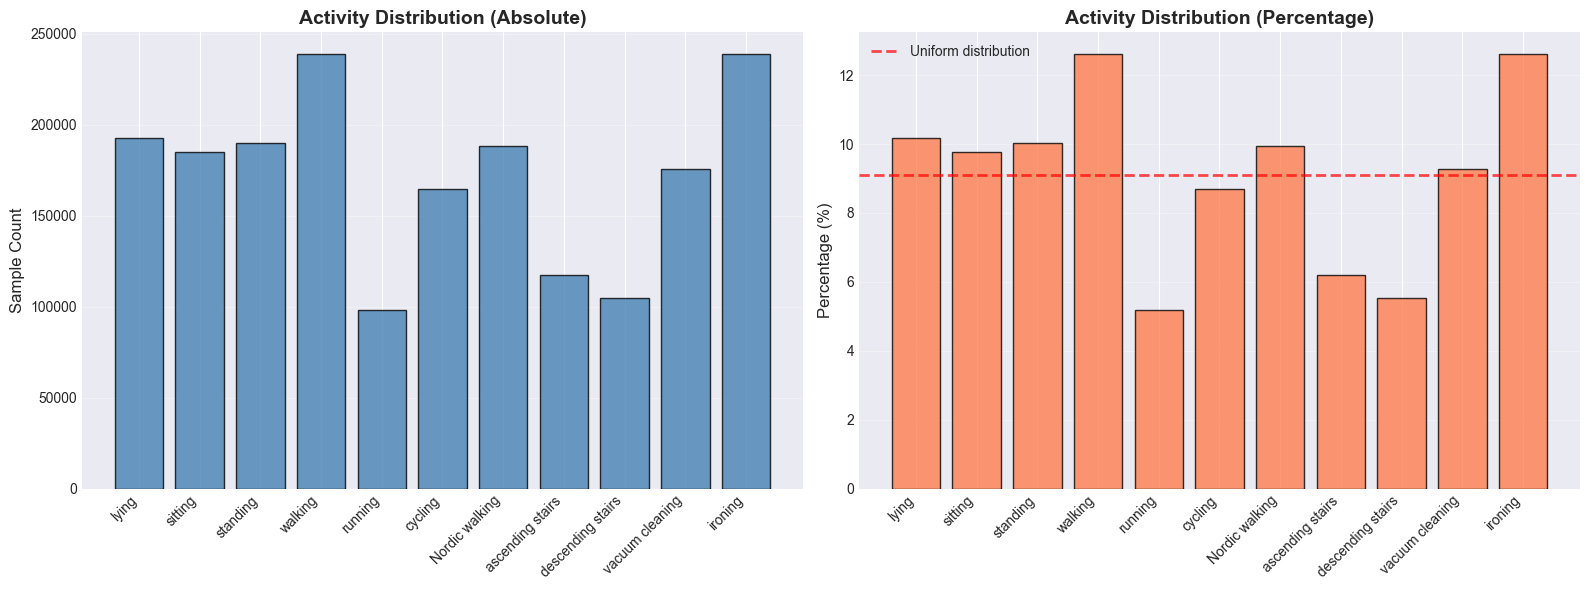

In [4]:
activity_counts = df_total["activityID"].value_counts().sort_index()
imbalance_ratio = activity_counts.max() / activity_counts.min()
# Visualize activity distribution with names
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
activity_counts_named = activity_counts.copy()
activity_counts_named.index = activity_counts_named.index.map(activity_map)

axes[0].bar(
	range(len(activity_counts_named)),
	activity_counts_named.values,
	color="steelblue",
	edgecolor="black",
	alpha=0.8,
)
axes[0].set_xticks(range(len(activity_counts_named)))
axes[0].set_xticklabels(activity_counts_named.index, rotation=45, ha="right")
axes[0].set_ylabel("Sample Count", fontsize=12)
axes[0].set_title("Activity Distribution (Absolute)", fontsize=14, fontweight="bold")
axes[0].grid(axis="y", alpha=0.3)

# Percentage distribution
activity_pct = activity_counts_named / activity_counts_named.sum() * 100
axes[1].bar(
	range(len(activity_pct)),
	activity_pct.values,
	color="coral",
	edgecolor="black",
	alpha=0.8,
)
axes[1].set_xticks(range(len(activity_pct)))
axes[1].set_xticklabels(activity_pct.index, rotation=45, ha="right")
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_title("Activity Distribution (Percentage)", fontsize=14, fontweight="bold")
axes[1].axhline(
	y=100 / len(activity_pct),
	color="red",
	linestyle="--",
	linewidth=2,
	label="Uniform distribution",
	alpha=0.7,
)
axes[1].legend(fontsize=10)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Samples per Subject:
subject
1    237032
2    250069
3    174332
4    231421
5    264631
6    249697
7    232761
8    253257
Name: count, dtype: int64


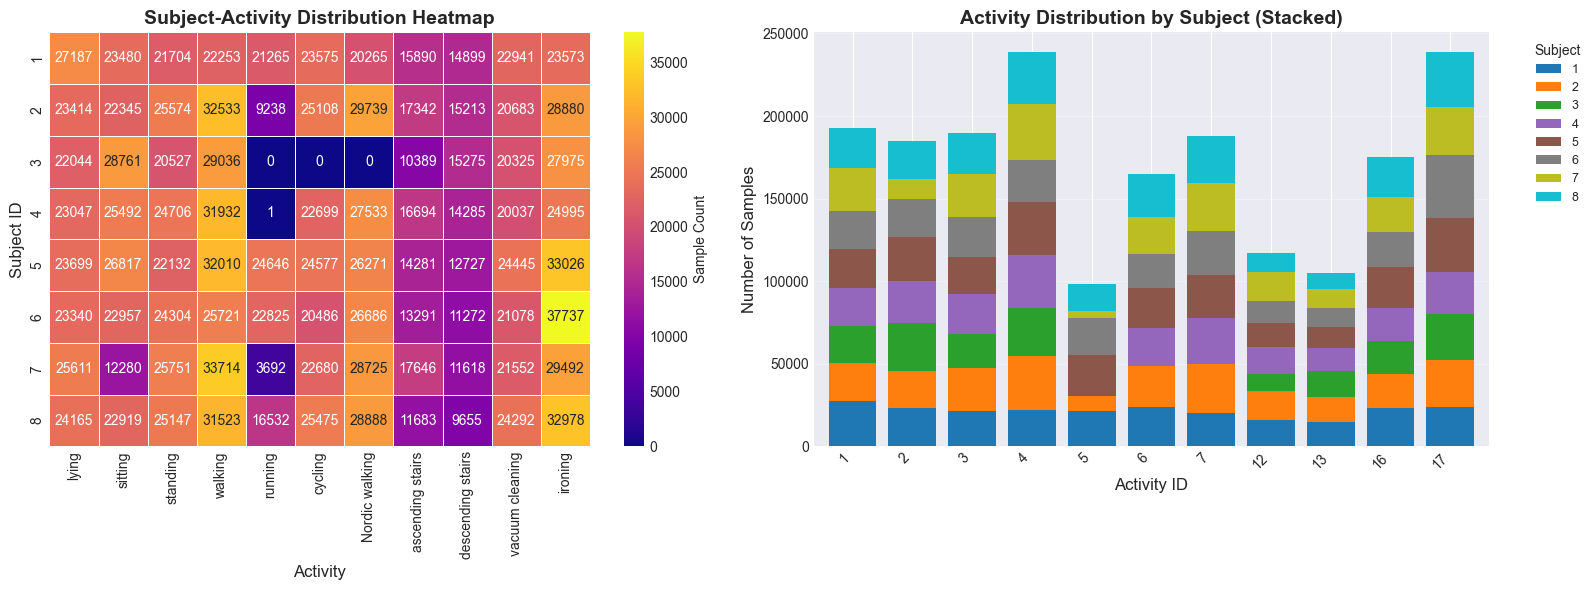

In [5]:
print("\nSamples per Subject:")
subject_counts = df_total["subject"].value_counts().sort_index()
print(subject_counts)

# Subject-Activity distribution
subject_activity_matrix = crosstab(df_total["subject"], df_total["activityID"])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
subject_activity_named = subject_activity_matrix.copy()
subject_activity_named.columns = subject_activity_named.columns.map(activity_map)

sns.heatmap(
	subject_activity_named,
	annot=True,
	fmt="d",
	cmap="plasma",
	linewidths=0.5,
	cbar_kws={"label": "Sample Count"},
	ax=axes[0],
)
axes[0].set_title(
	"Subject-Activity Distribution Heatmap", fontsize=14, fontweight="bold"
)
axes[0].set_xlabel("Activity", fontsize=12)
axes[0].set_ylabel("Subject ID", fontsize=12)

# Stacked bar chart
subject_activity_matrix.T.plot(
	kind="bar", stacked=True, ax=axes[1], colormap="tab10", width=0.8
)
axes[1].set_xlabel("Activity ID", fontsize=12)
axes[1].set_ylabel("Number of Samples", fontsize=12)
axes[1].set_title(
	"Activity Distribution by Subject (Stacked)", fontsize=14, fontweight="bold"
)
axes[1].legend(title="Subject", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
axes[1].grid(axis="y", alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


Temperature Statistics:
                       min       max      mean       std     range
IMU_hand_temp_C  -2.647059  1.117647 -0.138780  0.800778  3.764706
IMU_chest_temp_C -2.156250  1.093750 -0.064436  0.717625  3.250000
IMU_ankle_temp_C -2.826087  0.956522 -0.213705  0.729769  3.782609


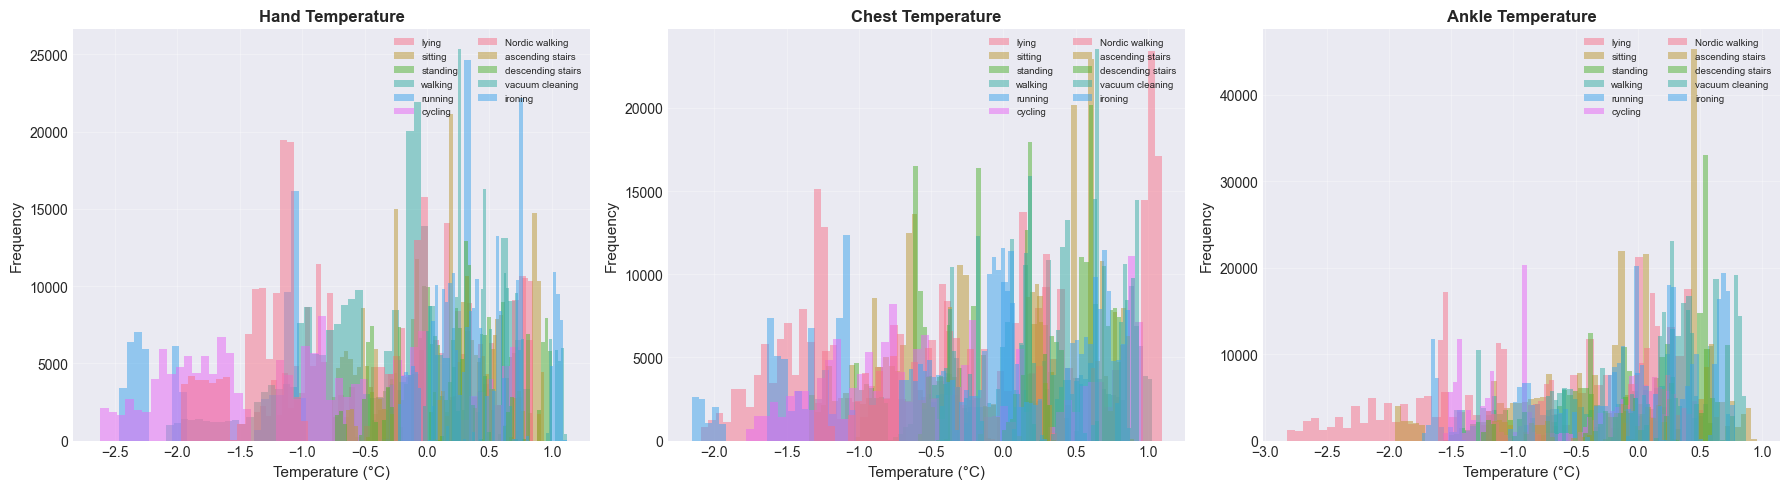

In [6]:
temp_cols = [col for col in SENSOR_COLS if "temp" in col]
acc_cols = [col for col in SENSOR_COLS if "acc16g" in col]
gyro_cols = [col for col in SENSOR_COLS if "gyro" in col]
mag_cols = [col for col in SENSOR_COLS if "mag" in col]

temp_stats = df_total[temp_cols].agg(["min", "max", "mean", "std"]).T
temp_stats["range"] = temp_stats["max"] - temp_stats["min"]
print("\nTemperature Statistics:")
print(temp_stats)

# Visualize temperature distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(temp_cols):
	ax = axes[idx]
	for activity_id in sorted(df_total["activityID"].unique()):
		activity_data = df_total[df_total["activityID"] == activity_id][feature]
		ax.hist(
			activity_data,
			bins=50,
			alpha=0.5,
			label=activity_map.get(activity_id, f"ID{activity_id}"),
		)
	ax.set_xlabel("Temperature (°C)", fontsize=11)
	ax.set_ylabel("Frequency", fontsize=11)
	ax.set_title(
		f"{feature.split('_')[1].capitalize()} Temperature",
		fontsize=12,
		fontweight="bold",
	)
	ax.legend(loc="upper right", fontsize=7, ncol=2)
	ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

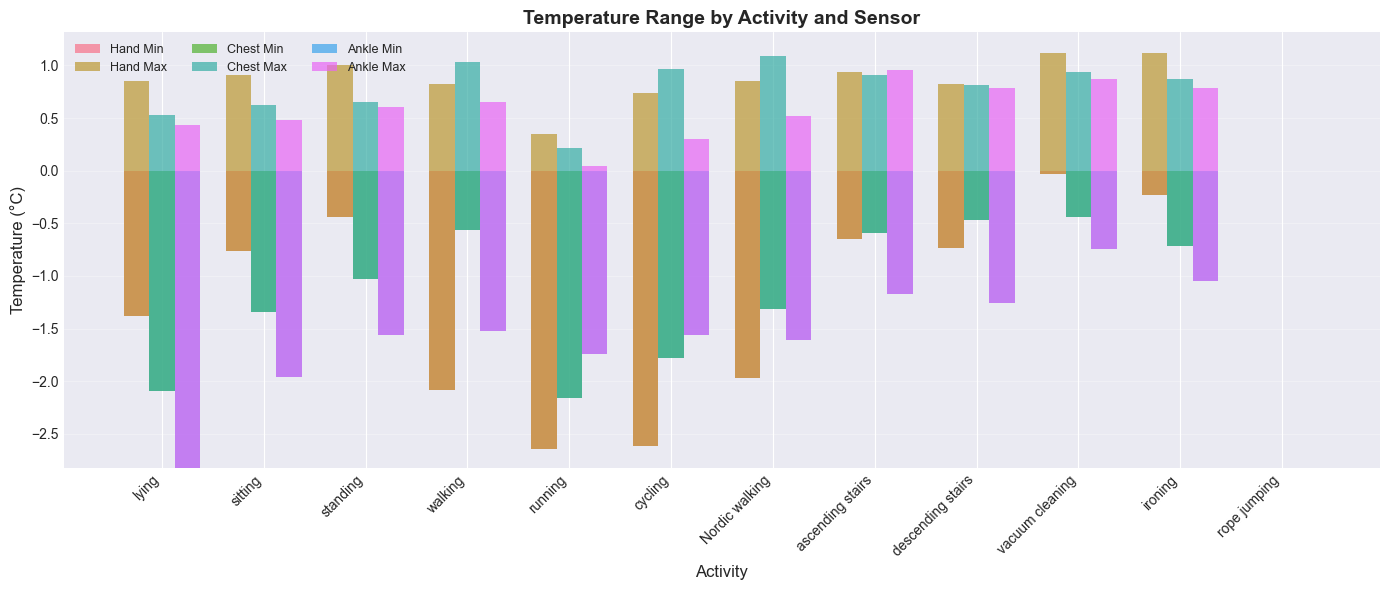

In [7]:
temp_by_activity = df_total.groupby("activityID")[temp_cols].agg(["min", "max", "mean"])

fig, ax = plt.subplots(figsize=(14, 6))
x_pos = arange(len(activity_map))
width = 0.25

for idx, sensor in enumerate(["hand", "chest", "ankle"]):
	col = f"IMU_{sensor}_temp_C"
	mins = [
		temp_by_activity.loc[aid, (col, "min")] if aid in temp_by_activity.index else 0
		for aid in sorted(activity_map.keys())
	]
	maxs = [
		temp_by_activity.loc[aid, (col, "max")] if aid in temp_by_activity.index else 0
		for aid in sorted(activity_map.keys())
	]
	ax.bar(
		x_pos + idx * width - width,
		mins,
		width,
		label=f"{sensor.capitalize()} Min",
		alpha=0.7,
	)
	ax.bar(
		x_pos + idx * width - width,
		array(maxs) - array(mins),
		width,
		bottom=mins,
		alpha=0.7,
		label=f"{sensor.capitalize()} Max",
	)
ax.set_xlabel("Activity", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.set_title("Temperature Range by Activity and Sensor", fontsize=14, fontweight="bold")
ax.set_xticks(x_pos)
ax.set_xticklabels(
	[activity_map[aid] for aid in sorted(activity_map.keys())], rotation=45, ha="right"
)
ax.legend(loc="upper left", fontsize=9, ncol=3)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

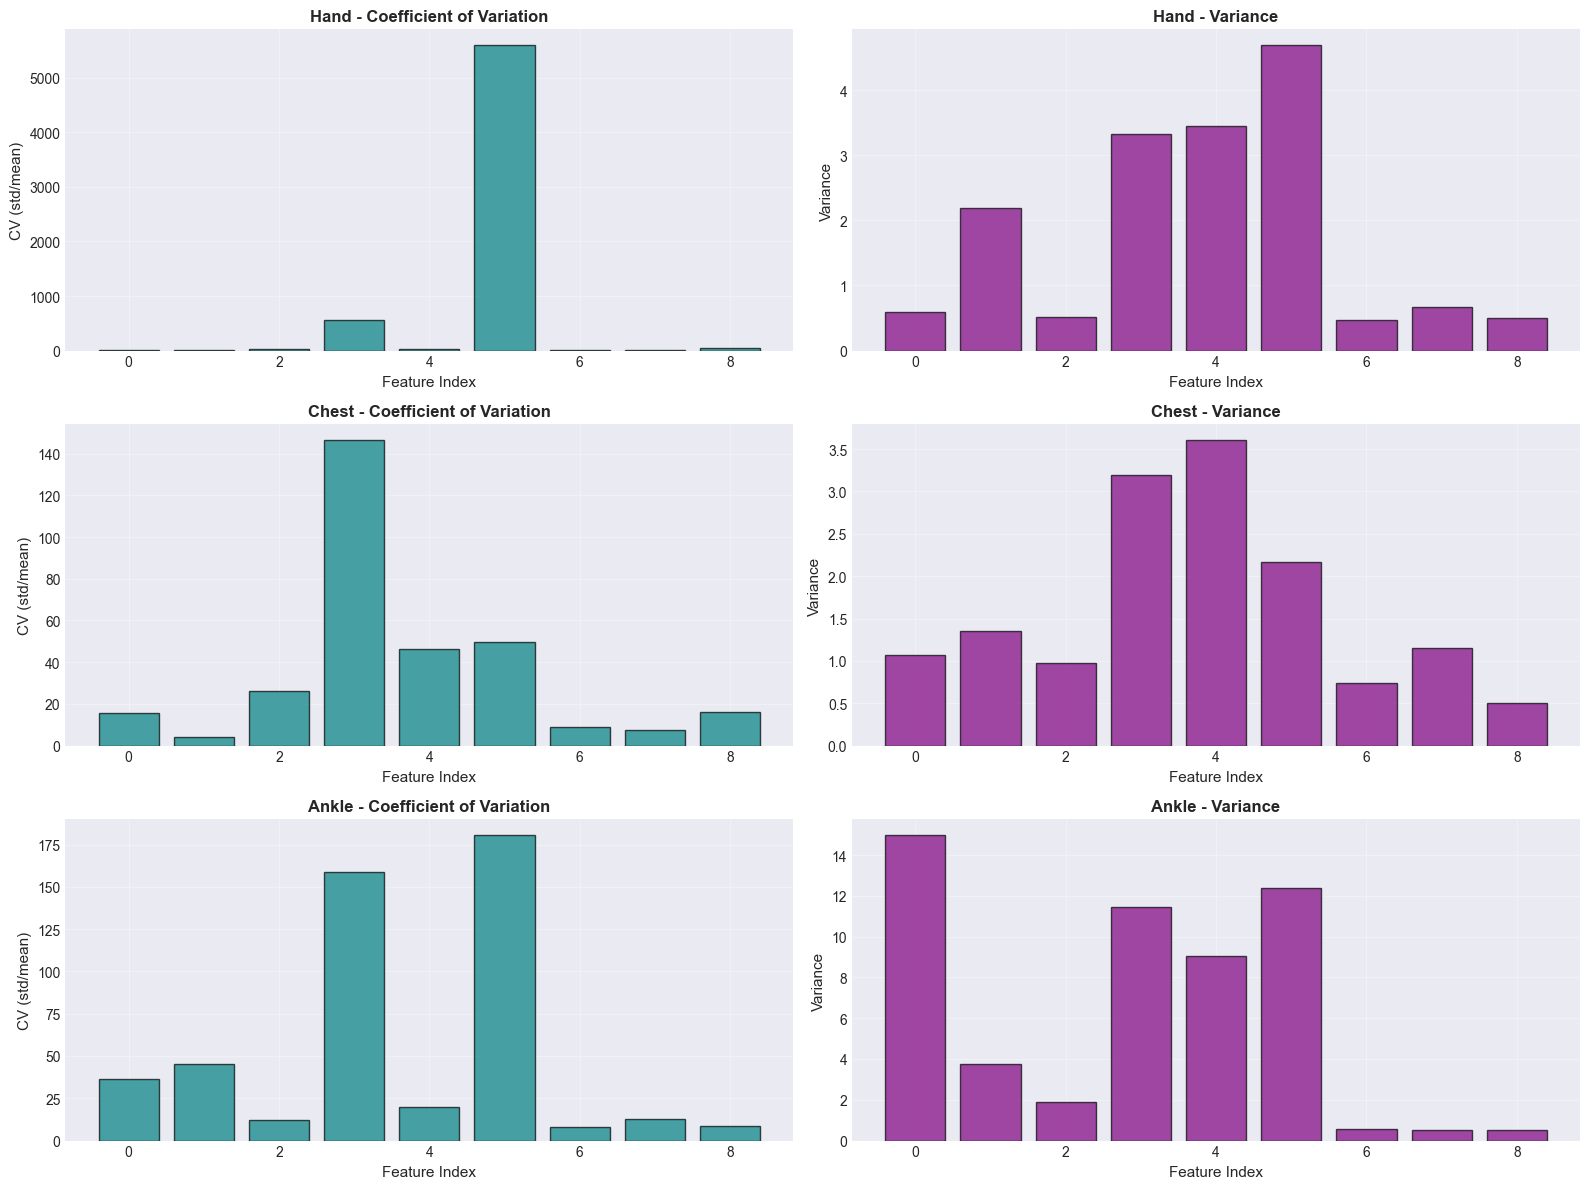


Total Variance by Sensor (Higher = More Informative):
    Hand: 16.4308
   Chest: 14.7767
   Ankle: 55.1223


In [8]:
sensor_groups = {
	"Hand": [col for col in SENSOR_COLS if "hand" in col and not col.endswith("_C")],
	"Chest": [col for col in SENSOR_COLS if "chest" in col and not col.endswith("_C")],
	"Ankle": [col for col in SENSOR_COLS if "ankle" in col and not col.endswith("_C")],
}
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for idx, (sensor_name, cols) in enumerate(sensor_groups.items()):
	# Coefficient of Variation (CV = std/mean)
	cv = (df_total[cols].std() / (df_total[cols].mean().abs() + 1e-8)).values
	variance = df_total[cols].var().values

	# Left: Coefficient of Variation
	axes[idx, 0].bar(range(len(cv)), cv, color="teal", alpha=0.7, edgecolor="black")
	axes[idx, 0].set_title(
		f"{sensor_name} - Coefficient of Variation", fontsize=12, fontweight="bold"
	)
	axes[idx, 0].set_xlabel("Feature Index", fontsize=11)
	axes[idx, 0].set_ylabel("CV (std/mean)", fontsize=11)
	axes[idx, 0].grid(alpha=0.3)

	# Right: Variance
	axes[idx, 1].bar(
		range(len(variance)), variance, color="purple", alpha=0.7, edgecolor="black"
	)
	axes[idx, 1].set_title(f"{sensor_name} - Variance", fontsize=12, fontweight="bold")
	axes[idx, 1].set_xlabel("Feature Index", fontsize=11)
	axes[idx, 1].set_ylabel("Variance", fontsize=11)
	axes[idx, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTotal Variance by Sensor (Higher = More Informative):")
for sensor_name, cols in sensor_groups.items():
	total_var = df_total[cols].var().sum()
	print(f"  {sensor_name:>6}: {total_var:.4f}")


Acceleration Magnitude Statistics:
       hand_acc_magnitude  chest_acc_magnitude  ankle_acc_magnitude
count        1.893200e+06         1.893200e+06         1.893200e+06
mean         1.371339e+00         1.510663e+00         2.822999e+00
std          1.199656e+00         1.097151e+00         3.566802e+00
min          9.414992e-03         1.534910e-02         4.661574e-03
25%          7.819404e-01         6.845976e-01         5.924500e-01
50%          1.151086e+00         1.175147e+00         1.231700e+00
75%          1.642492e+00         2.059200e+00         4.510967e+00
max          3.890268e+01         2.632575e+01         1.060613e+02


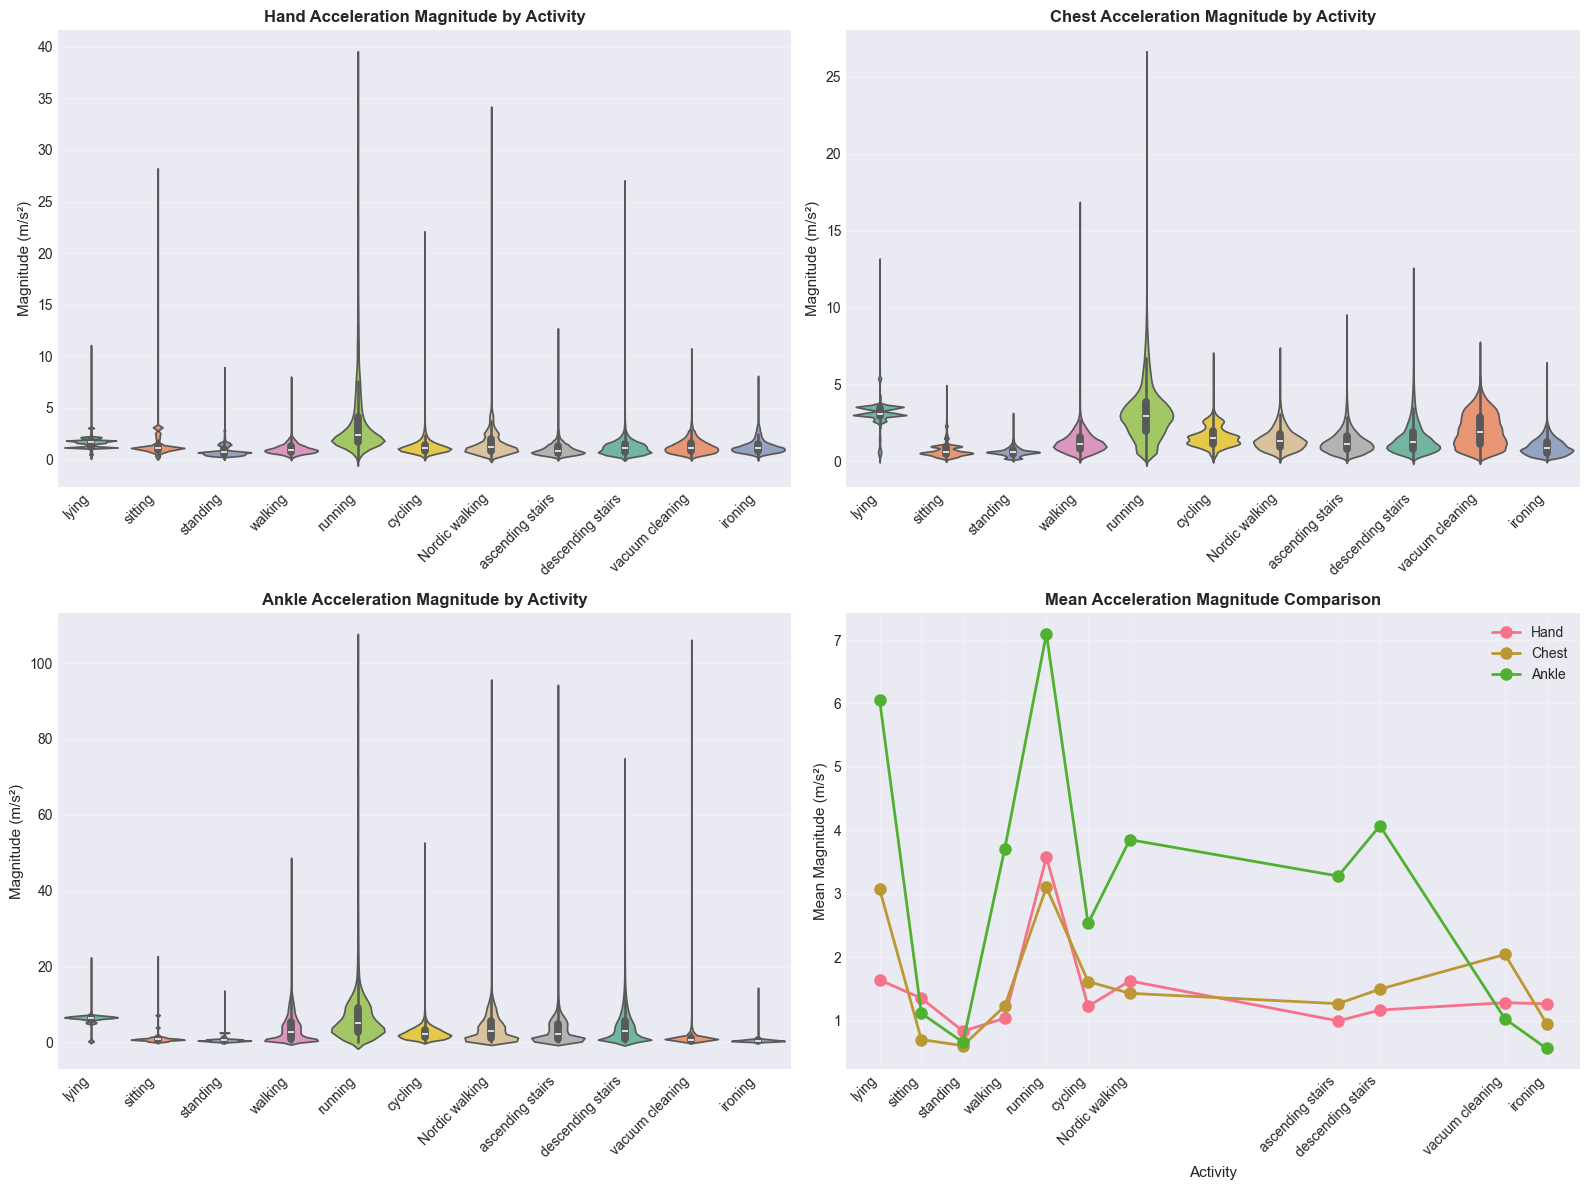

In [9]:
for sensor in ["hand", "chest", "ankle"]:
	df_total[f"{sensor}_acc_magnitude"] = sqrt(
		df_total[f"IMU_{sensor}_acc16g_ms^-2_x"] ** 2
		+ df_total[f"IMU_{sensor}_acc16g_ms^-2_y"] ** 2
		+ df_total[f"IMU_{sensor}_acc16g_ms^-2_z"] ** 2
	)

magnitude_cols = ["hand_acc_magnitude", "chest_acc_magnitude", "ankle_acc_magnitude"]

print("\nAcceleration Magnitude Statistics:")
print(df_total[magnitude_cols].describe())

# Visualize magnitude distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Violin plots for each sensor
for idx, col in enumerate(magnitude_cols):
	ax = axes[idx // 2, idx % 2]

	plot_data = df_total[["activityID", col]].copy()
	plot_data["activityName"] = plot_data["activityID"].map(activity_map)

	sns.violinplot(data=plot_data, x="activityName", y=col, ax=ax, palette="Set2")
	ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
	ax.set_title(
		f"{col.split('_')[0].capitalize()} Acceleration Magnitude by Activity",
		fontsize=12,
		fontweight="bold",
	)
	ax.set_xlabel("")
	ax.set_ylabel("Magnitude (m/s²)", fontsize=11)
	ax.grid(axis="y", alpha=0.3)

ax = axes[1, 1]
for col in magnitude_cols:
	mean_values = df_total.groupby("activityID")[col].mean()
	ax.plot(
		mean_values.index,
		mean_values.values,
		marker="o",
		linewidth=2,
		markersize=8,
		label=col.replace("_acc_magnitude", "").capitalize(),
	)

activity_labels = [activity_map[i] for i in sorted(df_total["activityID"].unique())]
ax.set_xticks(sorted(df_total["activityID"].unique()))
ax.set_xticklabels(activity_labels, rotation=45, ha="right")
ax.set_title("Mean Acceleration Magnitude Comparison", fontsize=12, fontweight="bold")
ax.set_ylabel("Mean Magnitude (m/s²)", fontsize=11)
ax.set_xlabel("Activity", fontsize=11)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Analyzing Activity 4 (walking), Subject 1
Sample size: 1000 points (~10.0 seconds at 100Hz)


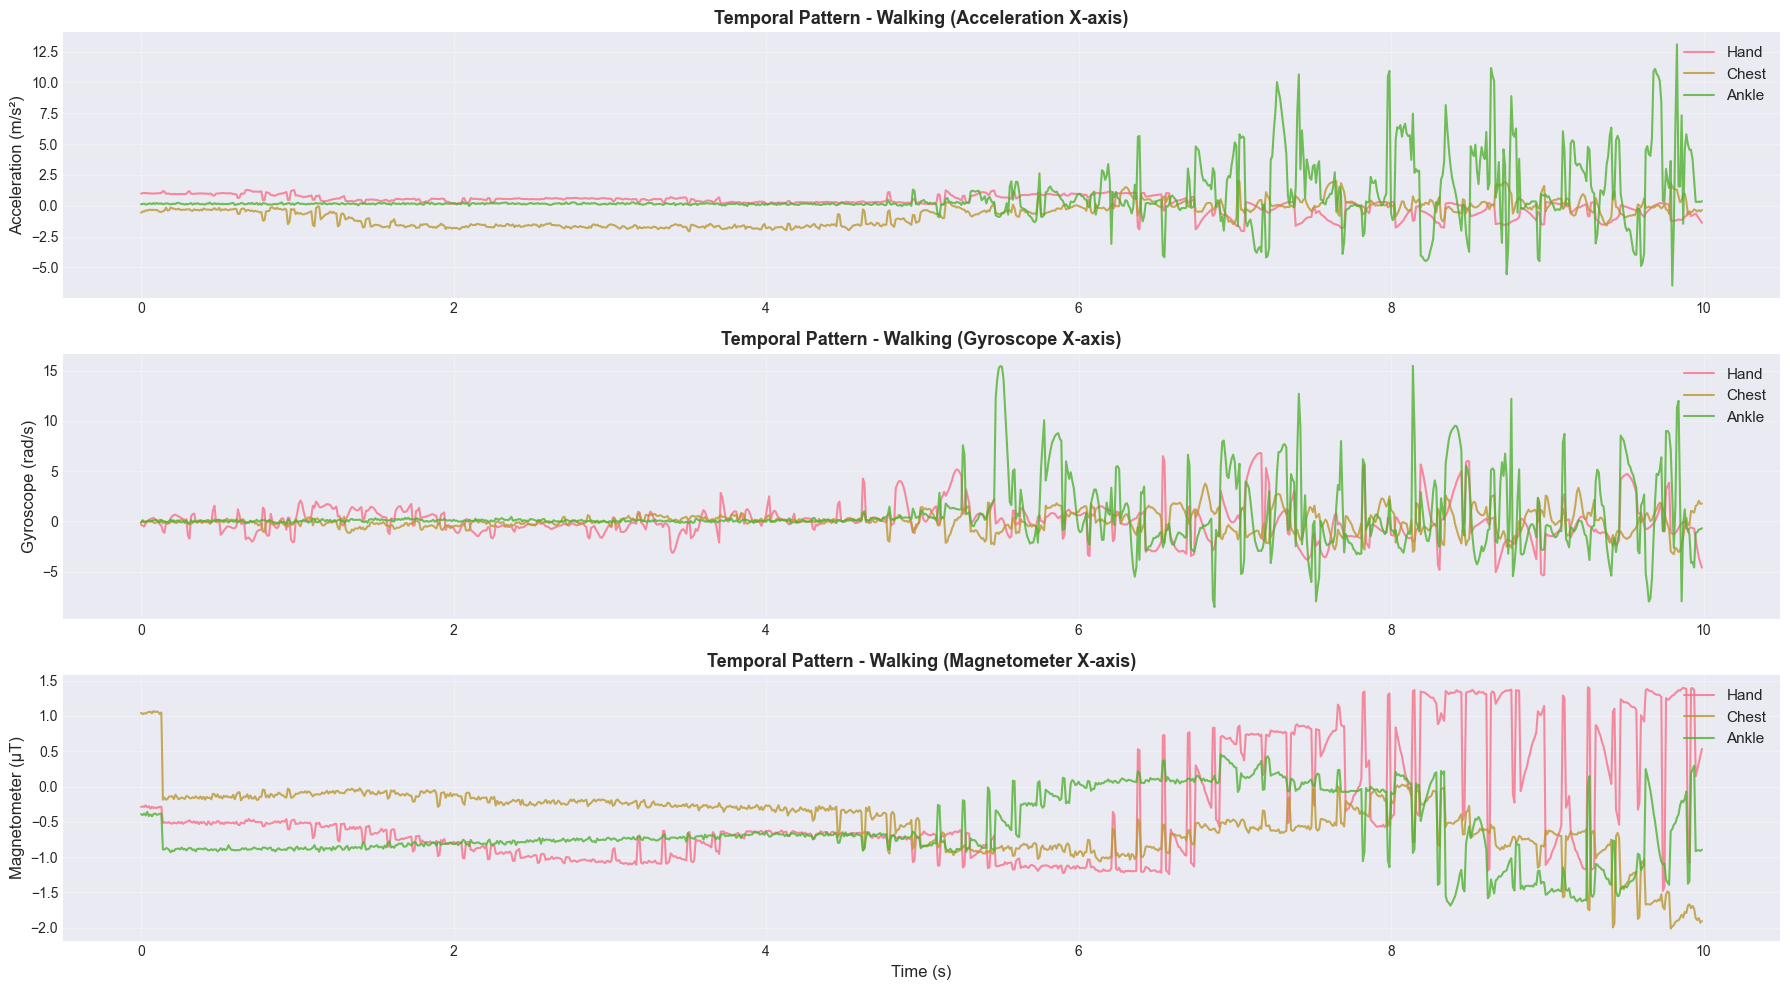

In [10]:
sample_activity = 4  # walking
sample_subject = 1

sample_data = (
	df_total[
		(df_total["activityID"] == sample_activity)
		& (df_total["subject"] == sample_subject)
	]
	.head(1000)
	.copy()
)

print(
	f"\nAnalyzing Activity {sample_activity} ({activity_map[sample_activity]}), Subject {sample_subject}"
)
print(
	f"Sample size: {len(sample_data)} points (~{len(sample_data) / 100:.1f} seconds at 100Hz)"
)

# Time series visualization
time_axis = arange(len(sample_data)) / 100  # Convert to seconds
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

sensors_to_plot = [
	("acc16g_ms^-2_x", "Acceleration (m/s²)", "Acceleration X-axis"),
	("gyro_rad/s_x", "Gyroscope (rad/s)", "Gyroscope X-axis"),
	("mag_μT_x", "Magnetometer (μT)", "Magnetometer X-axis"),
]

for i, (sensor, ylabel, title) in enumerate(sensors_to_plot):
	for location in ["hand", "chest", "ankle"]:
		axes[i].plot(
			time_axis,
			sample_data[f"IMU_{location}_{sensor}"],
			label=location.capitalize(),
			alpha=0.8,
			linewidth=1.5,
		)

	axes[i].set_ylabel(ylabel, fontsize=12)
	axes[i].set_title(
		f"Temporal Pattern - {activity_map[sample_activity].capitalize()} ({title})",
		fontsize=13,
		fontweight="bold",
	)
	axes[i].legend(loc="upper right", fontsize=11)
	axes[i].grid(alpha=0.3)

axes[2].set_xlabel("Time (s)", fontsize=12)
plt.tight_layout()
plt.show()

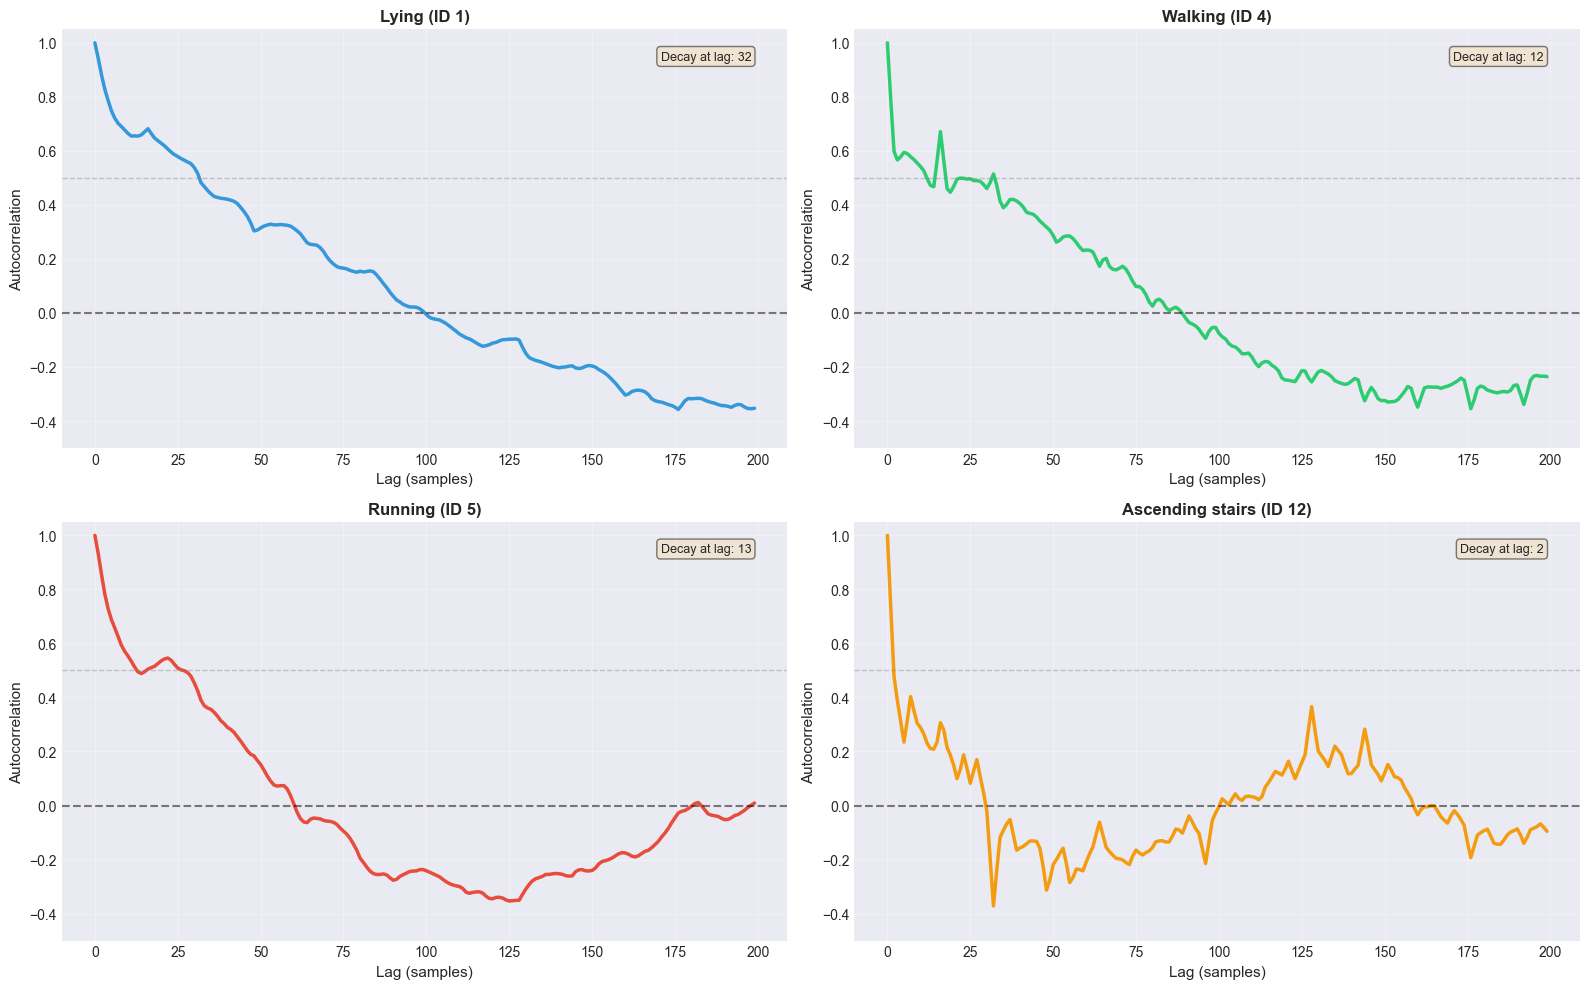

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

activities_for_autocorr = [1, 4, 5, 12]  # lying, walking, running, ascending stairs
colors_autocorr = ["#3498db", "#2ecc71", "#e74c3c", "#f39c12"]

for idx, (activity_id, color) in enumerate(
	zip(activities_for_autocorr, colors_autocorr)
):
	ax = axes[idx // 2, idx % 2]

	activity_sample = df_total[
		(df_total["activityID"] == activity_id) & (df_total["subject"] == 1)
	].head(500)

	if len(activity_sample) > 50:
		signal = activity_sample["IMU_hand_acc16g_ms^-2_z"].values

		# Compute autocorrelation
		autocorr = correlate(
			signal - signal.mean(), signal - signal.mean(), mode="full"
		)
		autocorr = autocorr[len(autocorr) // 2 :]
		autocorr = autocorr / autocorr[0]  # Normalize

		lags = arange(len(autocorr))

		ax.plot(lags[:200], autocorr[:200], color=color, linewidth=2.5)
		ax.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.5)
		ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, alpha=0.4)
		ax.set_xlabel("Lag (samples)", fontsize=11)
		ax.set_ylabel("Autocorrelation", fontsize=11)
		ax.set_title(
			f"{activity_map[activity_id].capitalize()} (ID {activity_id})",
			fontsize=12,
			fontweight="bold",
		)
		ax.grid(alpha=0.3)
		ax.set_ylim([-0.5, 1.05])

		# Add text with decay information
		decay_lag = argmax(autocorr[:100] < 0.5) if any(autocorr[:100] < 0.5) else 100
		ax.text(
			0.95,
			0.95,
			f"Decay at lag: {decay_lag}",
			transform=ax.transAxes,
			fontsize=9,
			verticalalignment="top",
			horizontalalignment="right",
			bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
		)
plt.tight_layout()
plt.show()

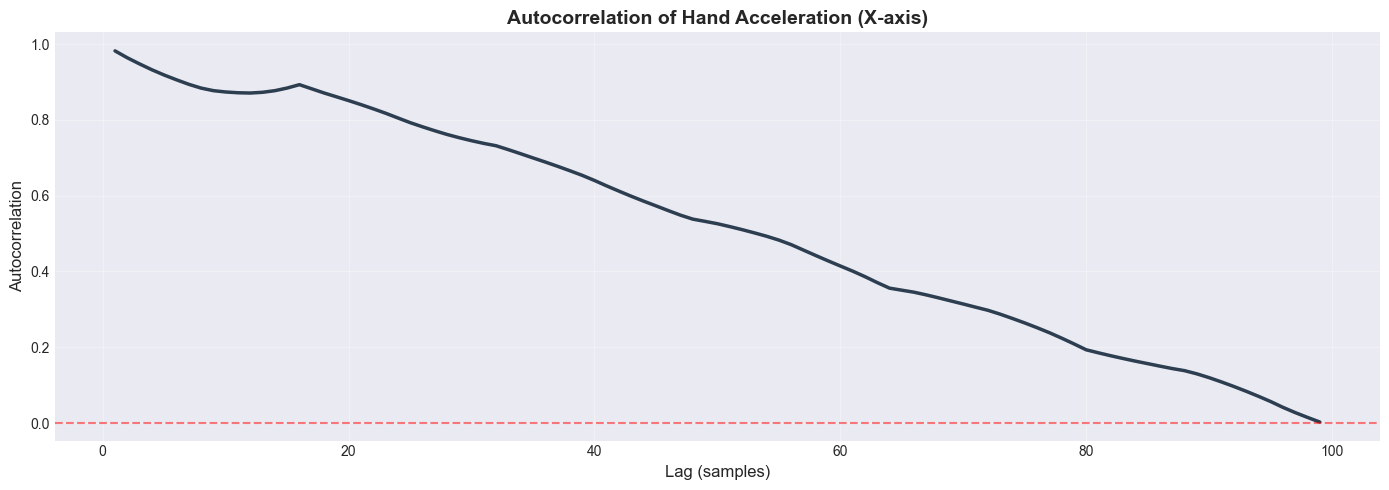

Strong autocorrelation persists for ~53 samples


In [12]:
# Simple autocorrelation for single signal
sample_signal = df_total["IMU_hand_acc16g_ms^-2_x"].iloc[:1000].values
lags = range(1, 100)
autocorr_simple = [
	corrcoef(sample_signal[:-lag], sample_signal[lag:])[0, 1] for lag in lags
]

plt.figure(figsize=(14, 5))
plt.plot(lags, autocorr_simple, linewidth=2.5, color="#2c3e50")
plt.xlabel("Lag (samples)", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title(
	"Autocorrelation of Hand Acceleration (X-axis)", fontsize=14, fontweight="bold"
)
plt.axhline(y=0, color="red", linestyle="--", alpha=0.5, linewidth=1.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

strong_autocorr_lag = argmax(array(autocorr_simple) < 0.5)
print(f"Strong autocorrelation persists for ~{strong_autocorr_lag} samples")

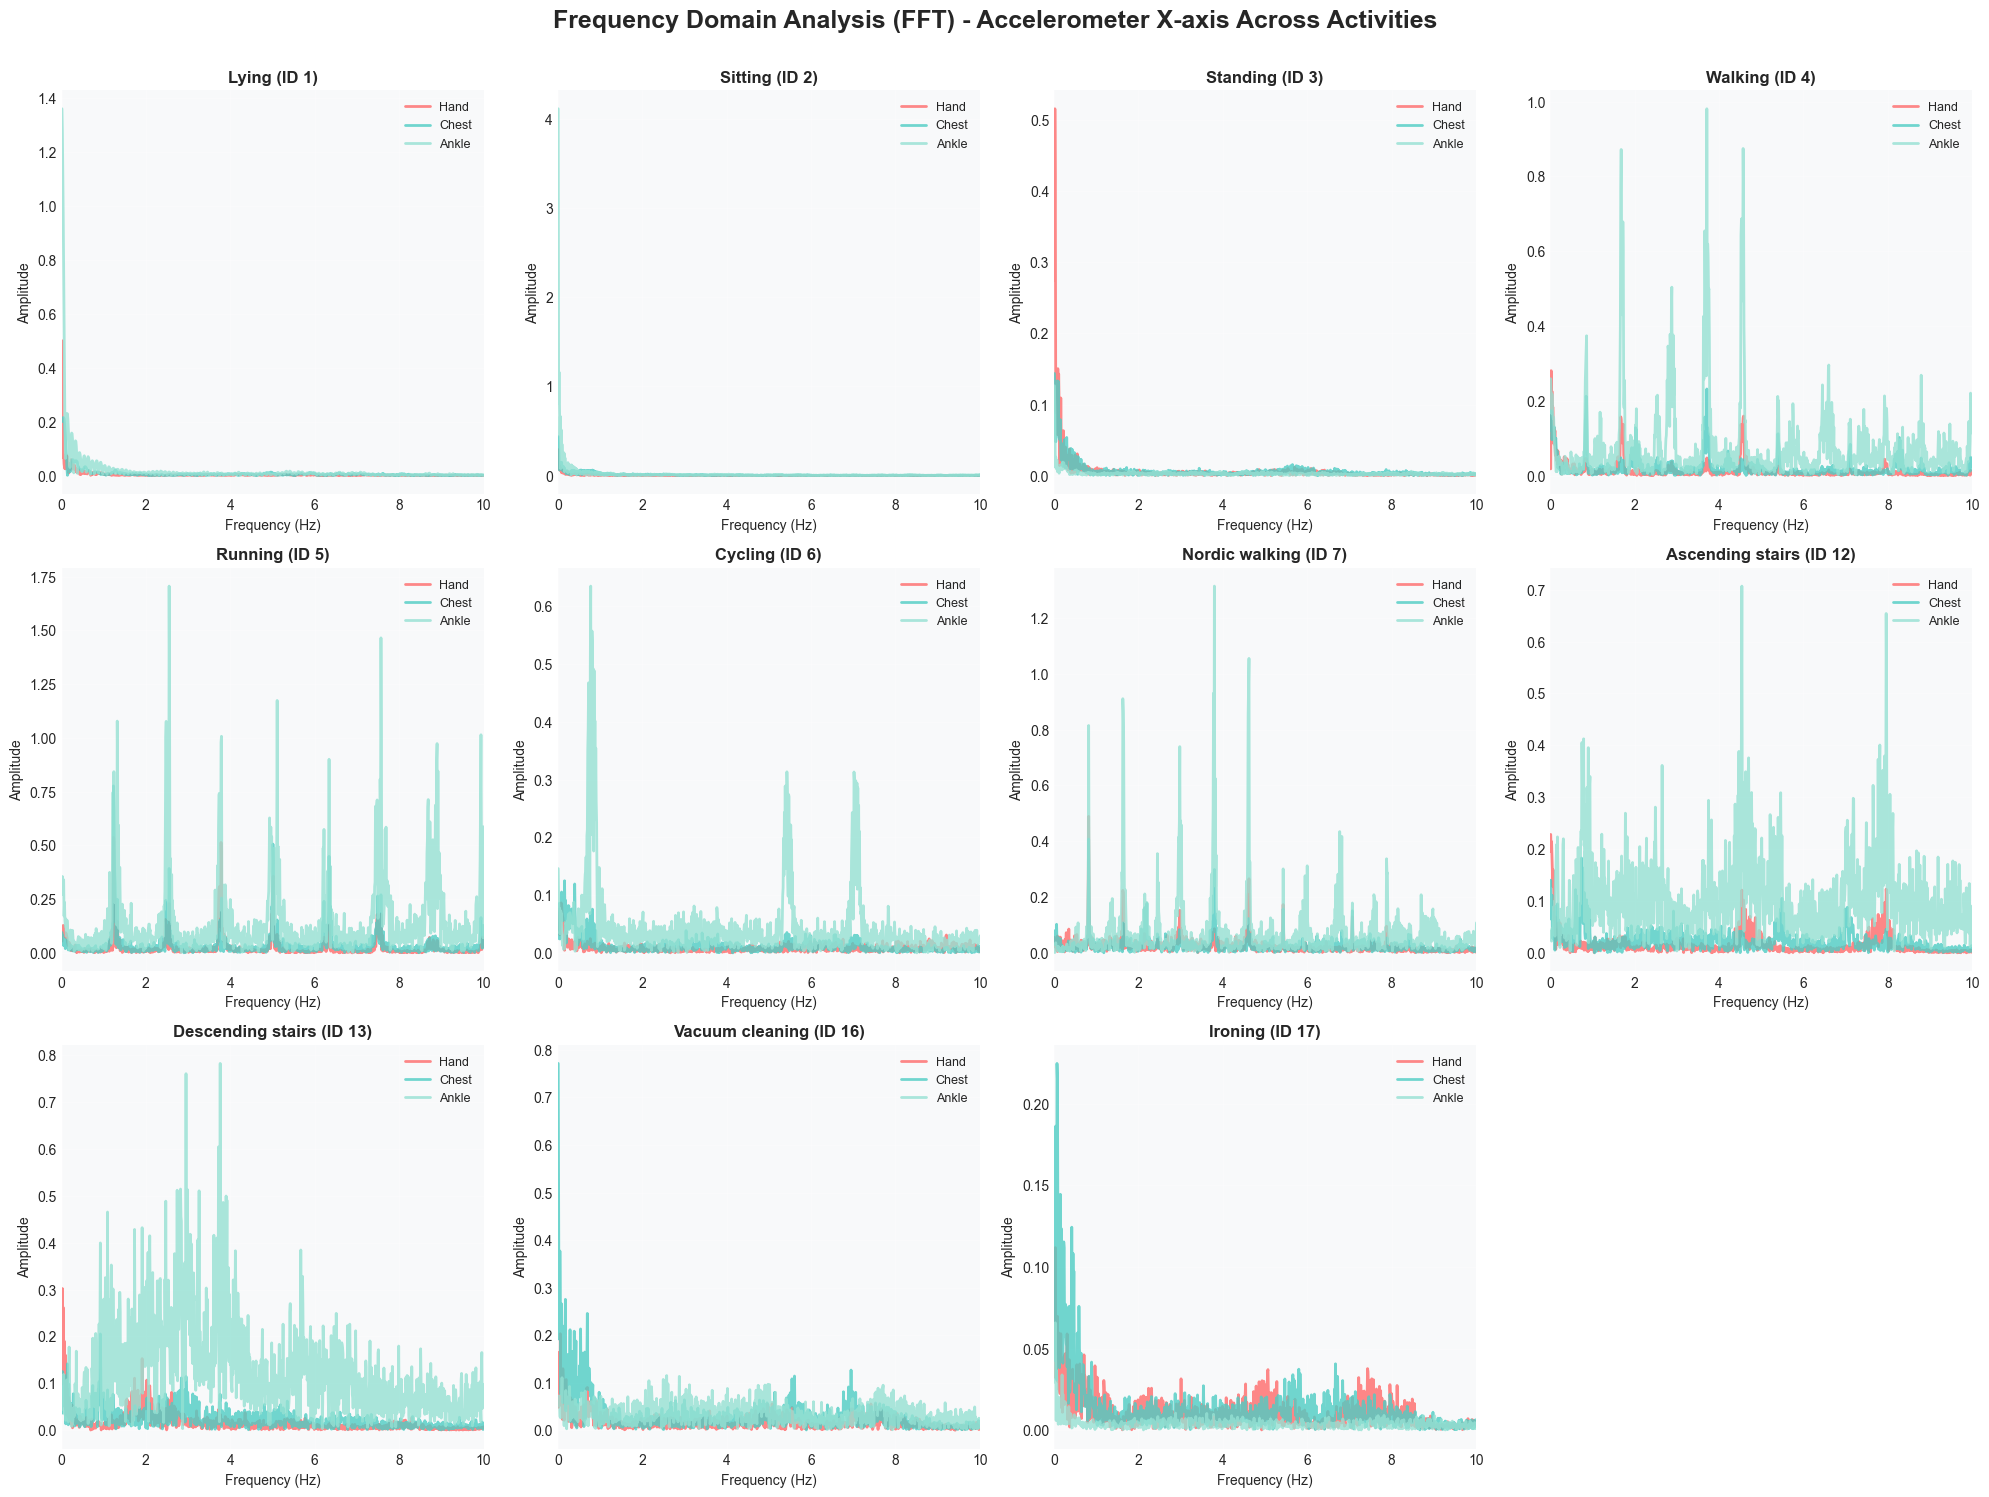

In [13]:
sampling_rate = 100  # Hz
activities_for_fft = sorted(df_total["activityID"].unique())
colors_fft = {"hand": "#FF6B6B", "chest": "#4ECDC4", "ankle": "#95E1D3"}

n_cols = 4
n_rows = (len(activities_for_fft) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

fig.suptitle(
	"Frequency Domain Analysis (FFT) - Accelerometer X-axis Across Activities",
	fontsize=18,
	fontweight="bold",
	y=0.995,
)
for idx, activity_id in enumerate(activities_for_fft):
	ax = axes[idx]
	activity_data = df_total[df_total["activityID"] == activity_id]

	for body_part in ["hand", "chest", "ankle"]:
		sensor_col = f"IMU_{body_part}_acc16g_ms^-2_x"

		if sensor_col not in activity_data.columns:
			continue

		if len(signal := activity_data[sensor_col].values) < sampling_rate:
			continue

		# Sample of the signal (10000 samples = 100s window)
		signal_sample = signal[: min(10000, len(signal))]

		N = len(signal_sample)
		fft_values = fft(signal_sample)
		fft_freqs = fftfreq(N, 1 / sampling_rate)

		ax.plot(  # Only positive frequencies
			fft_freqs[fft_freqs > 0],
			2.0 / N * abs(fft_values[fft_freqs > 0]),
			label=body_part.capitalize(),
			color=colors_fft[body_part],
			linewidth=2,
			alpha=0.8,
		)

	activity_name = activity_map.get(activity_id, f"ID{activity_id}")
	ax.set_title(
		f"{activity_name.capitalize()} (ID {activity_id})",
		fontsize=12,
		fontweight="bold",
	)
	ax.set_xlabel("Frequency (Hz)", fontsize=10)
	ax.set_ylabel("Amplitude", fontsize=10)
	ax.grid(True, alpha=0.3)
	ax.set_xlim(0, 10)  # Focus on 0-10 Hz (human motion range)
	ax.legend(loc="upper right", fontsize=9)
	ax.set_facecolor("#F8F9FA")

# Hide unused subplots
for idx in range(len(activities_for_fft), len(axes)):
	axes[idx].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


Computing correlation matrix for 18 features...


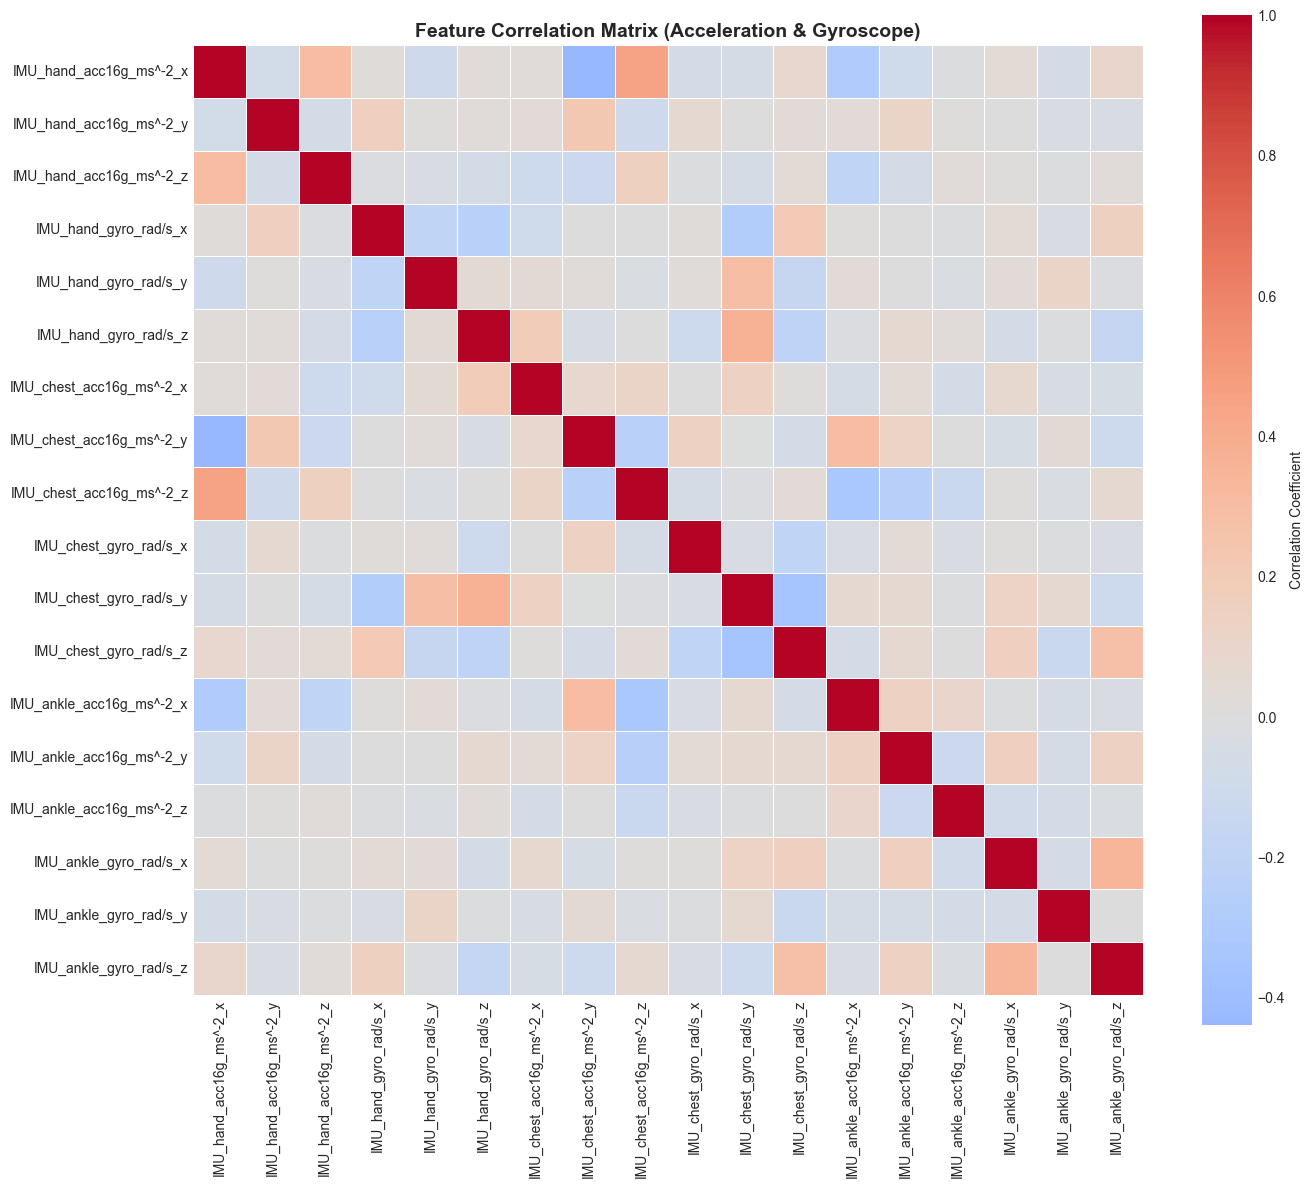


No feature pairs with |r| > 0.9


In [14]:
# Select relevant features (exclude temperature and magnetometer for clearer visualization)
correlation_features = [
	col for col in SENSOR_COLS if not col.endswith("_C") and "mag_μT" not in col
]

print(f"\nComputing correlation matrix for {len(correlation_features)} features...")

correlation_matrix = df_total[correlation_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
	correlation_matrix,
	annot=False,
	cmap="coolwarm",
	center=0,
	square=True,
	linewidths=0.5,
	cbar_kws={"label": "Correlation Coefficient"},
)
plt.title(
	"Feature Correlation Matrix (Acceleration & Gyroscope)",
	fontsize=14,
	fontweight="bold",
)
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
	for j in range(i + 1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
			high_corr_pairs.append(
				{
					"feature1": correlation_matrix.columns[i],
					"feature2": correlation_matrix.columns[j],
					"correlation": correlation_matrix.iloc[i, j],
				}
			)

if high_corr_pairs:
	print(f"\nHighly correlated feature pairs (|r| > {high_corr_threshold}):")
	for pair in high_corr_pairs[:10]:  # Show top 10
		print(f"  {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")
else:
	print(f"\nNo feature pairs with |r| > {high_corr_threshold}")

In [15]:
window_size = 100  # 1 second at 100Hz
overlap = 50  # 50% overlap
step = window_size - overlap

print(f"\nWindow Configuration:")
print(f"  Window size: {window_size} samples (1.0s at 100Hz)")
print(f"  Overlap: {overlap} samples ({overlap / window_size * 100:.0f}%)")
print(f"  Step size: {step} samples")

# Sample windowing for a subset of data (using subject 1 for demonstration)
windowing_sample = df_total[df_total["subject"] == 1].head(10000).reset_index(drop=True)

print(f"\nSample data for windowing: {len(windowing_sample)} points")
print(f"Expected windows: ~{(len(windowing_sample) - window_size) // step}")

# Create windows and extract features
windows_data = []
window_labels = []

for start_idx in range(0, len(windowing_sample) - window_size + 1, step):
	window = windowing_sample.iloc[start_idx : start_idx + window_size]

	# Ensure single activity in window (purity check)
	activity_counts_window = window["activityID"].value_counts()
	if len(activity_counts_window) == 1:
		# Extract features
		window_features = {}

		for col in SENSOR_COLS:
			values = window[col].values

			# Time-domain features
			window_features[f"{col}_mean"] = mean(values)
			window_features[f"{col}_std"] = std(values)
			window_features[f"{col}_min"] = min(values)
			window_features[f"{col}_max"] = max(values)
			window_features[f"{col}_range"] = max(values) - min(values)
			window_features[f"{col}_skew"] = stats.skew(values)
			window_features[f"{col}_kurtosis"] = stats.kurtosis(values)
			window_features[f"{col}_energy"] = sum(values**2)
			window_features[f"{col}_rms"] = sqrt(mean(values**2))

		windows_data.append(window_features)
		window_labels.append(activity_counts_window.index[0])

windows_df = DataFrame(windows_data)
windows_df["activityID"] = window_labels

print(f"\nWindowing Results:")
print(f"  Extracted windows: {len(windows_df)}")
print(f"  Features per window: {len(windows_df.columns) - 1}")
print(f"  Total features: {len(windows_df.columns) - 1}")

print(f"\nWindow distribution by activity:")
for activity_id, count in windows_df["activityID"].value_counts().sort_index().items():
	print(
		f"  Activity {activity_id} ({activity_map.get(activity_id, 'Unknown')}): {count} windows"
	)

print("\nSample of extracted features (first 5 columns):")
windows_df.iloc[:, :5].describe()


Window Configuration:
  Window size: 100 samples (1.0s at 100Hz)
  Overlap: 50 samples (50%)
  Step size: 50 samples

Sample data for windowing: 10000 points
Expected windows: ~198

Windowing Results:
  Extracted windows: 199
  Features per window: 270
  Total features: 270

Window distribution by activity:
  Activity 1 (lying): 199 windows

Sample of extracted features (first 5 columns):


,IMU_hand_temp_C_mean,IMU_hand_temp_C_std,IMU_hand_temp_C_min,IMU_hand_temp_C_max,IMU_hand_temp_C_range
count,199.000000,1.990000e+02,199.000000,199.000000,199.000000
mean,-1.086923,2.690861e-03,-1.090304,-1.083654,0.006651
std,0.098875,5.201336e-03,0.099959,0.098354,0.012335
min,-1.294118,0.000000e+00,-1.294118,-1.294118,0.000000
25%,-1.176471,0.000000e+00,-1.176471,-1.176471,0.000000
50%,-1.088235,2.220446e-16,-1.088235,-1.088235,0.000000
75%,-1.000000,4.440892e-16,-1.000000,-1.000000,0.000000
max,-0.941176,1.470588e-02,-0.941176,-0.941176,0.029412



PCA Results on Raw Data:
  Total components: 30
  Components for 95% variance: 18
  Components for 99% variance: 25


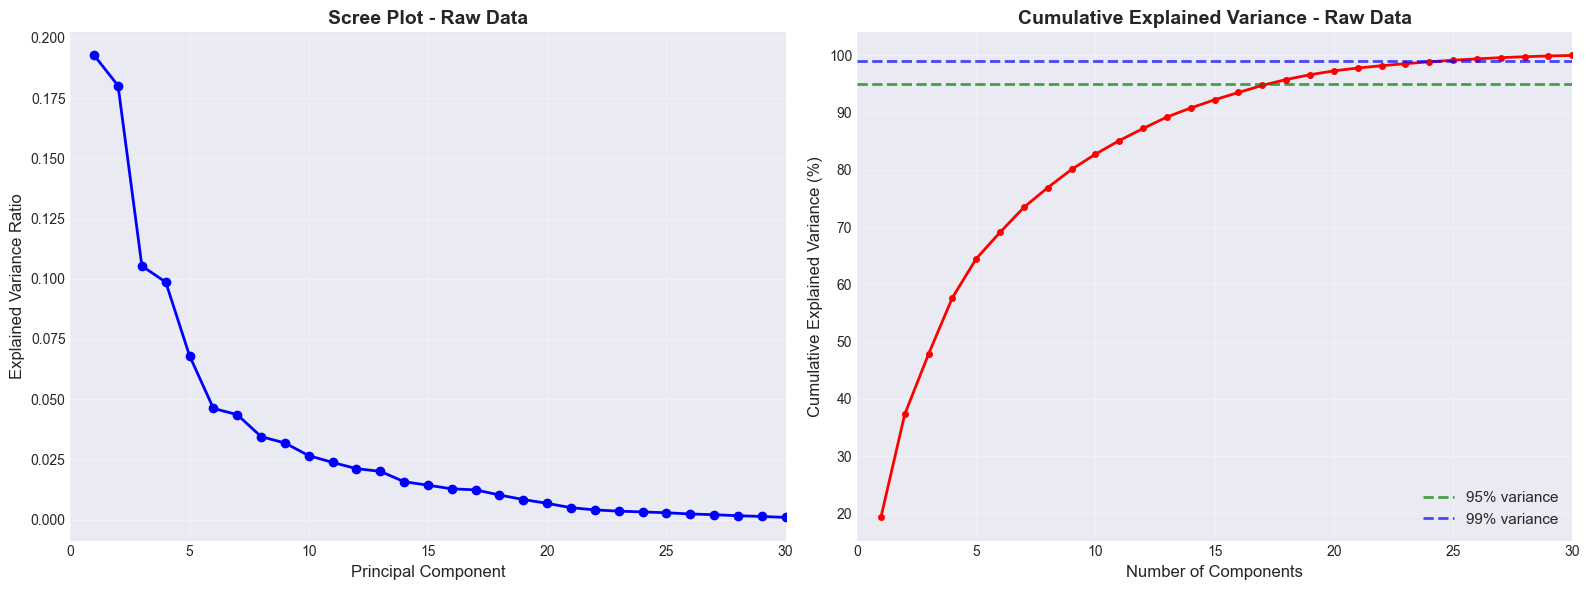

In [16]:
pca_full = PCA()
pca_full.fit(df_total[SENSOR_COLS])

cumsum_full = cumsum(pca_full.explained_variance_ratio_)
n_components_95 = argmax(cumsum_full >= 0.95) + 1
n_components_99 = argmax(cumsum_full >= 0.99) + 1

print(f"\nPCA Results on Raw Data:")
print(f"  Total components: {len(pca_full.explained_variance_ratio_)}")
print(f"  Components for 95% variance: {n_components_95}")
print(f"  Components for 99% variance: {n_components_99}")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].plot(
	range(1, len(pca_full.explained_variance_ratio_) + 1),
	pca_full.explained_variance_ratio_,
	"bo-",
	linewidth=2,
	markersize=6,
)
axes[0].set_xlabel("Principal Component", fontsize=12)
axes[0].set_ylabel("Explained Variance Ratio", fontsize=12)
axes[0].set_title("Scree Plot - Raw Data", fontsize=14, fontweight="bold")
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, min(30, len(pca_full.explained_variance_ratio_))])

# Cumulative variance
axes[1].plot(
	range(1, len(cumsum_full) + 1), cumsum_full * 100, "ro-", linewidth=2, markersize=4
)
axes[1].axhline(
	y=95, color="green", linestyle="--", linewidth=2, label="95% variance", alpha=0.7
)
axes[1].axhline(
	y=99, color="blue", linestyle="--", linewidth=2, label="99% variance", alpha=0.7
)
axes[1].set_xlabel("Number of Components", fontsize=12)
axes[1].set_ylabel("Cumulative Explained Variance (%)", fontsize=12)
axes[1].set_title(
	"Cumulative Explained Variance - Raw Data", fontsize=14, fontweight="bold"
)
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, min(30, len(cumsum_full))])

plt.tight_layout()
plt.show()

In [17]:
print("\nTop Contributing Features per Principal Component:")
for i in range(min(3, len(pca_full.components_))):
	print(
		f"\nPC{i + 1} (explains {pca_full.explained_variance_ratio_[i] * 100:.2f}% variance):"
	)
	loadings = DataFrame({"feature": SENSOR_COLS, "loading": pca_full.components_[i]})
	loadings["abs_loading"] = abs(loadings["loading"])
	loadings = loadings.sort_values("abs_loading", ascending=False)
	print(loadings.head(10)[["feature", "loading"]].to_string(index=False))


Top Contributing Features per Principal Component:

PC1 (explains 19.27% variance):
                 feature   loading
  IMU_ankle_gyro_rad/s_z  0.679882
  IMU_ankle_gyro_rad/s_x  0.573083
IMU_ankle_acc16g_ms^-2_x -0.393486
  IMU_chest_gyro_rad/s_z  0.122909
   IMU_hand_gyro_rad/s_z -0.104983
   IMU_hand_gyro_rad/s_x  0.075656
IMU_chest_acc16g_ms^-2_y -0.068334
IMU_ankle_acc16g_ms^-2_y  0.058431
IMU_chest_acc16g_ms^-2_z  0.047950
      IMU_chest_mag_μT_y  0.043777

PC2 (explains 18.02% variance):
                 feature   loading
IMU_ankle_acc16g_ms^-2_x  0.872540
  IMU_ankle_gyro_rad/s_x  0.282981
  IMU_ankle_gyro_rad/s_z  0.269870
IMU_ankle_acc16g_ms^-2_y  0.141150
  IMU_ankle_gyro_rad/s_y -0.113912
      IMU_chest_mag_μT_y -0.110010
IMU_chest_acc16g_ms^-2_y  0.085869
IMU_chest_acc16g_ms^-2_z -0.084126
      IMU_chest_mag_μT_x -0.066733
   IMU_hand_gyro_rad/s_z -0.052788

PC3 (explains 10.53% variance):
                 feature   loading
  IMU_ankle_gyro_rad/s_y  0.935455
  IMU_ank

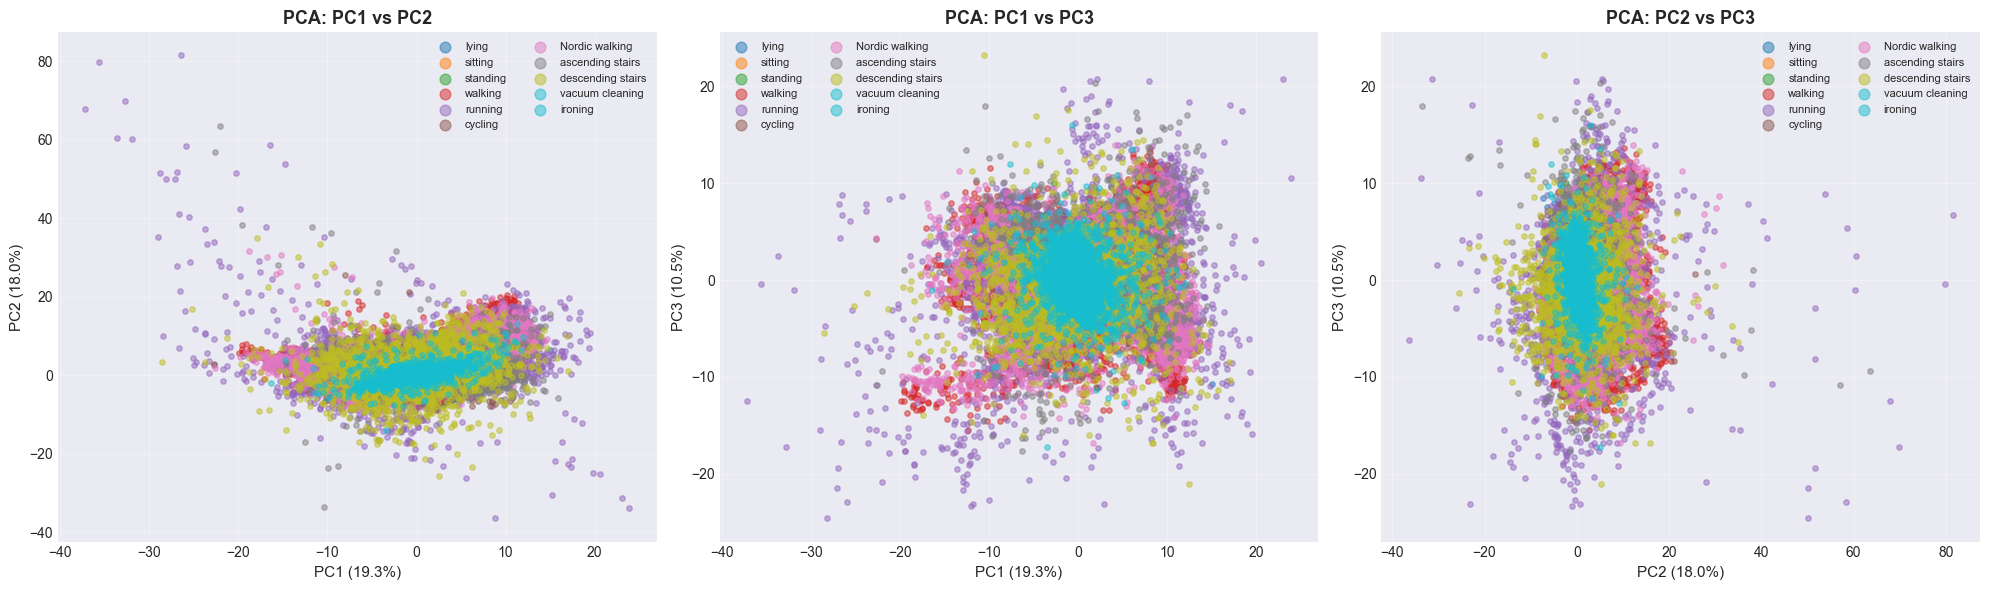

In [18]:
pca_viz = PCA(n_components=3)
df_pca = pca_viz.fit_transform(df_total[SENSOR_COLS])

# Create visualization dataframe with sampling for performance
sample_size = min(50000, len(df_total))
sample_indices = array(range(0, len(df_total), max(1, len(df_total) // sample_size)))

df_viz = DataFrame(
	{
		"PC1": df_pca[sample_indices, 0],
		"PC2": df_pca[sample_indices, 1],
		"PC3": df_pca[sample_indices, 2],
		"activityID": df_total.iloc[sample_indices]["activityID"].values,
	}
)

# 2D PCA plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

unique_activities_viz = sorted(df_viz["activityID"].unique())
colors_activity = plt.cm.tab10(linspace(0, 1, len(unique_activities_viz)))

# PC1 vs PC2
ax = axes[0]
for idx, activity_id in enumerate(unique_activities_viz):
	mask = df_viz["activityID"] == activity_id
	ax.scatter(
		df_viz.loc[mask, "PC1"],
		df_viz.loc[mask, "PC2"],
		label=activity_map.get(activity_id, f"ID{activity_id}"),
		alpha=0.5,
		s=15,
		c=[colors_activity[idx]],
	)
ax.set_xlabel(f"PC1 ({pca_viz.explained_variance_ratio_[0] * 100:.1f}%)", fontsize=11)
ax.set_ylabel(f"PC2 ({pca_viz.explained_variance_ratio_[1] * 100:.1f}%)", fontsize=11)
ax.set_title("PCA: PC1 vs PC2", fontsize=13, fontweight="bold")
ax.legend(markerscale=2, fontsize=8, ncol=2)
ax.grid(alpha=0.3)

# PC1 vs PC3
ax = axes[1]
for idx, activity_id in enumerate(unique_activities_viz):
	mask = df_viz["activityID"] == activity_id
	ax.scatter(
		df_viz.loc[mask, "PC1"],
		df_viz.loc[mask, "PC3"],
		label=activity_map.get(activity_id, f"ID{activity_id}"),
		alpha=0.5,
		s=15,
		c=[colors_activity[idx]],
	)
ax.set_xlabel(f"PC1 ({pca_viz.explained_variance_ratio_[0] * 100:.1f}%)", fontsize=11)
ax.set_ylabel(f"PC3 ({pca_viz.explained_variance_ratio_[2] * 100:.1f}%)", fontsize=11)
ax.set_title("PCA: PC1 vs PC3", fontsize=13, fontweight="bold")
ax.legend(markerscale=2, fontsize=8, ncol=2)
ax.grid(alpha=0.3)

# PC2 vs PC3
ax = axes[2]
for idx, activity_id in enumerate(unique_activities_viz):
	mask = df_viz["activityID"] == activity_id
	ax.scatter(
		df_viz.loc[mask, "PC2"],
		df_viz.loc[mask, "PC3"],
		label=activity_map.get(activity_id, f"ID{activity_id}"),
		alpha=0.5,
		s=15,
		c=[colors_activity[idx]],
	)
ax.set_xlabel(f"PC2 ({pca_viz.explained_variance_ratio_[1] * 100:.1f}%)", fontsize=11)
ax.set_ylabel(f"PC3 ({pca_viz.explained_variance_ratio_[2] * 100:.1f}%)", fontsize=11)
ax.set_title("PCA: PC2 vs PC3", fontsize=13, fontweight="bold")
ax.legend(markerscale=2, fontsize=8, ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
print(len(windows_df.columns))
for col in windows_df.columns:
	if "temp_C" in col and col.endswith("skew") or col.endswith("kurtosis"):
		windows_df.drop(col, axis=1, inplace=True)

print(len(windows_df.columns))

271
238



Windowed Feature Matrix:
  Shape: (199, 237)
  Number of windows: 199
  Features per window: 237
  Unique activities: 1

PCA on Windowed Features:
  Components analyzed: 50

Explained variance by first 10 components:
  PC1: 83.62%
  PC2: 11.12%
  PC3: 1.97%
  PC4: 1.15%
  PC5: 0.74%
  PC6: 0.50%
  PC7: 0.34%
  PC8: 0.25%
  PC9: 0.09%
  PC10: 0.06%

Cumulative variance:
  First 5 components: 98.60%
  First 10 components: 99.85%
  First 20 components: 100.00%


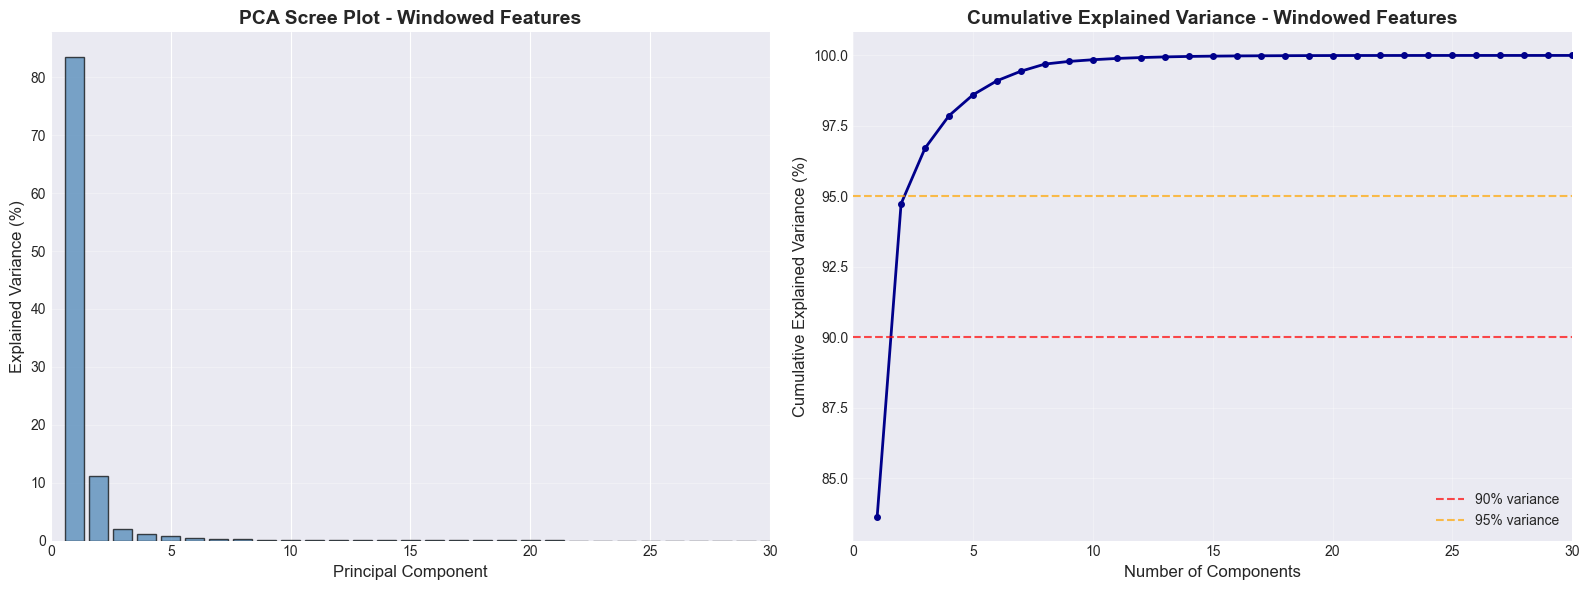

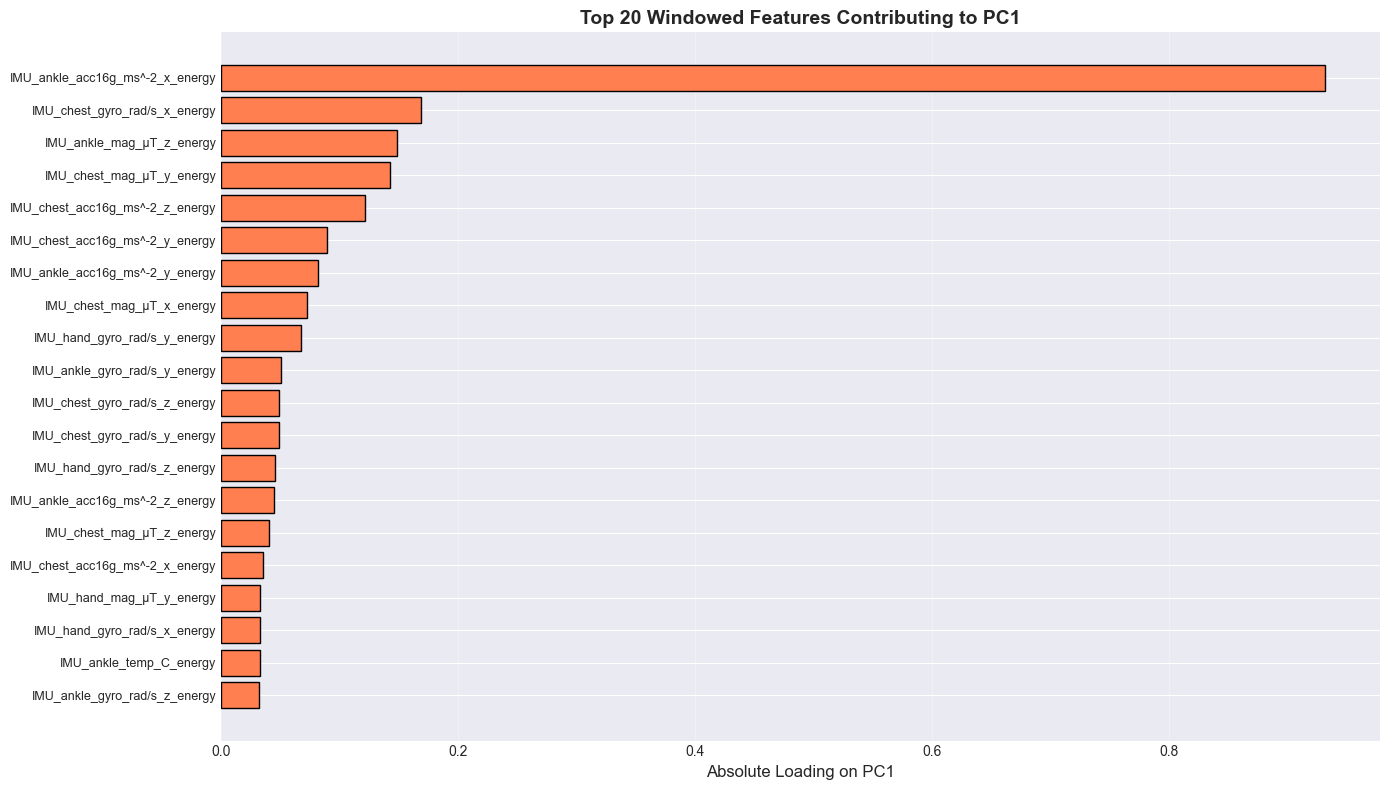

In [24]:
X_windows = windows_df.drop("activityID", axis=1).values
y_windows = windows_df["activityID"].values

print(f"\nWindowed Feature Matrix:")
print(f"  Shape: {X_windows.shape}")
print(f"  Number of windows: {X_windows.shape[0]}")
print(f"  Features per window: {X_windows.shape[1]}")
print(f"  Unique activities: {len(unique(y_windows))}")

# PCA analysis on windowed features
n_components_pca = min(50, X_windows.shape[1])
pca_windows = PCA(n_components=n_components_pca)
X_pca_windows = pca_windows.fit_transform(X_windows)

print(f"\nPCA on Windowed Features:")
print(f"  Components analyzed: {n_components_pca}")

print(f"\nExplained variance by first 10 components:")
for i in range(min(10, n_components_pca)):
	print(f"  PC{i + 1}: {pca_windows.explained_variance_ratio_[i] * 100:.2f}%")

cumsum_windows = cumsum(pca_windows.explained_variance_ratio_)
print(f"\nCumulative variance:")
print(f"  First 5 components: {cumsum_windows[4] * 100:.2f}%")
print(f"  First 10 components: {cumsum_windows[9] * 100:.2f}%")
if len(cumsum_windows) > 19:
	print(f"  First 20 components: {cumsum_windows[19] * 100:.2f}%")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].bar(
	range(1, n_components_pca + 1),
	pca_windows.explained_variance_ratio_ * 100,
	color="steelblue",
	edgecolor="black",
	alpha=0.7,
)
axes[0].set_xlabel("Principal Component", fontsize=12)
axes[0].set_ylabel("Explained Variance (%)", fontsize=12)
axes[0].set_title("PCA Scree Plot - Windowed Features", fontsize=14, fontweight="bold")
axes[0].grid(axis="y", alpha=0.3)
axes[0].set_xlim([0, min(30, n_components_pca + 1)])

# Cumulative variance
axes[1].plot(
	range(1, n_components_pca + 1),
	cumsum_windows * 100,
	marker="o",
	linewidth=2,
	markersize=4,
	color="darkblue",
)
axes[1].axhline(
	y=90, color="red", linestyle="--", linewidth=1.5, label="90% variance", alpha=0.7
)
axes[1].axhline(
	y=95, color="orange", linestyle="--", linewidth=1.5, label="95% variance", alpha=0.7
)
axes[1].set_xlabel("Number of Components", fontsize=12)
axes[1].set_ylabel("Cumulative Explained Variance (%)", fontsize=12)
axes[1].set_title(
	"Cumulative Explained Variance - Windowed Features", fontsize=14, fontweight="bold"
)
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, min(30, n_components_pca + 1)])

plt.tight_layout()
plt.show()

# Feature importance from PC1
feature_importance_pc1 = abs(pca_windows.components_[0])
feature_names_windows = windows_df.drop("activityID", axis=1).columns
top_n = 20

top_features_idx = argsort(feature_importance_pc1)[-top_n:][::-1]
top_features_names = feature_names_windows[top_features_idx]
top_features_values = feature_importance_pc1[top_features_idx]

plt.figure(figsize=(14, 8))
plt.barh(range(top_n), top_features_values, color="coral", edgecolor="black")
plt.yticks(range(top_n), [name[:60] for name in top_features_names], fontsize=9)
plt.xlabel("Absolute Loading on PC1", fontsize=12)
plt.title(
	f"Top {top_n} Windowed Features Contributing to PC1", fontsize=14, fontweight="bold"
)
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()